In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libararies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler  # Ensure this is installed
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [3]:
# LOAD DATASET
df = pd.read_csv("/content/drive/MyDrive/archive/HAM10000_metadata.csv")
print("Initial Shape:", df.shape)

Initial Shape: (10015, 7)


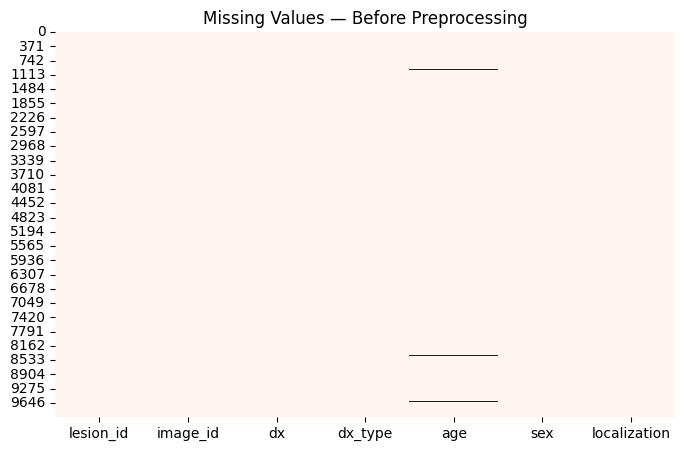

In [4]:
# Missing Values Before
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title("Missing Values — Before Preprocessing")
plt.show()

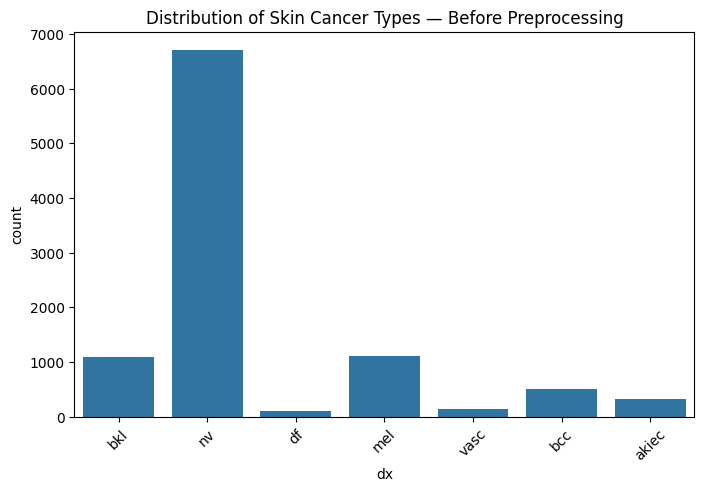

In [5]:
# Class Distribution Before
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='dx')
plt.title("Distribution of Skin Cancer Types — Before Preprocessing")
plt.xticks(rotation=45)
plt.show()

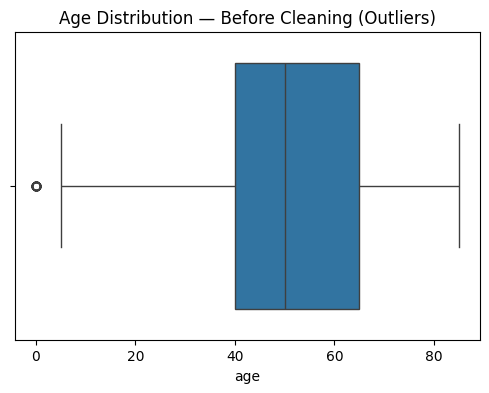

In [6]:
# Age Distribution Before
plt.figure(figsize=(6,4))
sns.boxplot(x=df['age'])
plt.title("Age Distribution — Before Cleaning (Outliers)")
plt.show()

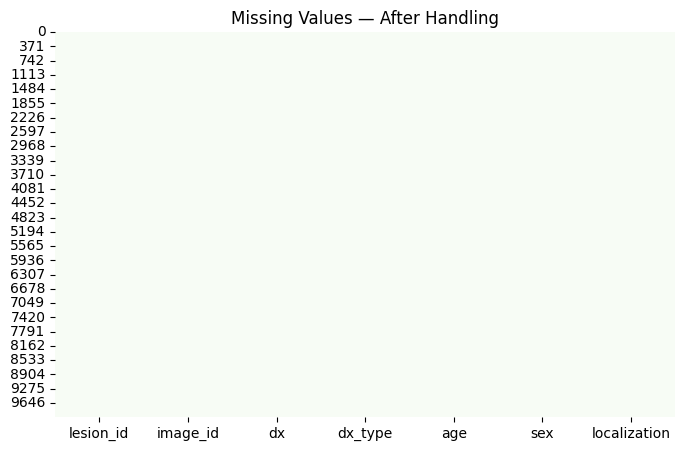

In [7]:
# HANDLE MISSING DATA
df['age'] = df['age'].fillna(df['age'].mean())
df.dropna(subset=['dx'], inplace=True)

# Missing Values After
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(), cbar=False, cmap='Greens')
plt.title("Missing Values — After Handling")
plt.show()

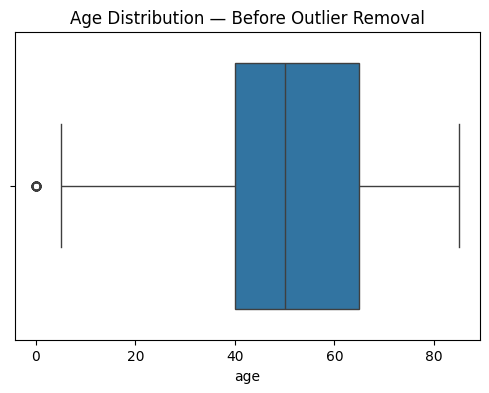

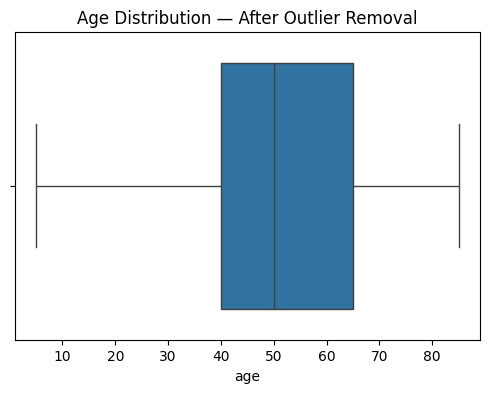

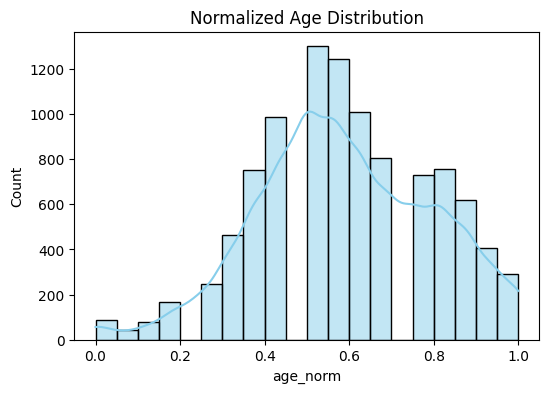

In [8]:
# AGE OUTLIER REMOVAL

# Before Outlier Removal
plt.figure(figsize=(6,4))
sns.boxplot(x=df['age'])
plt.title("Age Distribution — Before Outlier Removal")
plt.show()

# Remove Outliers
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['age'] >= Q1 - 1.5*IQR) & (df['age'] <= Q3 + 1.5*IQR)]

# After Outlier Removal
plt.figure(figsize=(6,4))
sns.boxplot(x=df['age'])
plt.title("Age Distribution — After Outlier Removal")
plt.show()

# Normalized Age Distribution
df['age_norm'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())
plt.figure(figsize=(6,4))
sns.histplot(df['age_norm'], bins=20, kde=True, color='skyblue')
plt.title("Normalized Age Distribution")
plt.show()

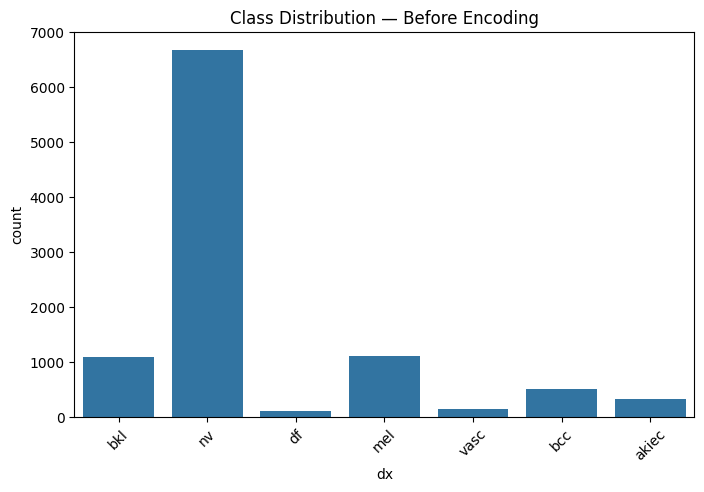

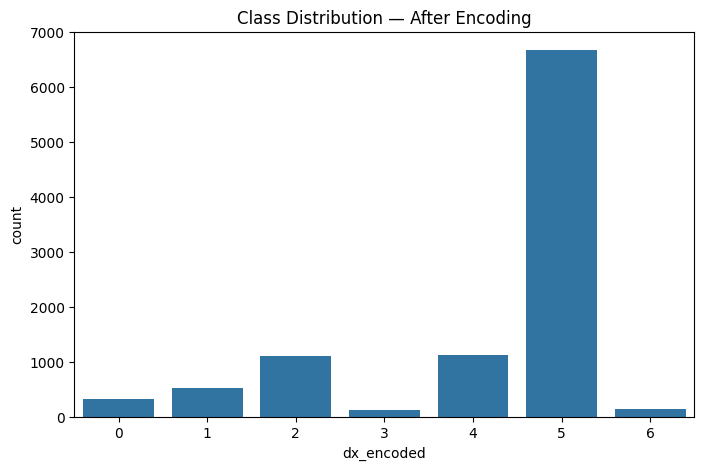

In [9]:
# LABEL ENCODING
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['dx_encoded'] = encoder.fit_transform(df['dx'])

# Before Encoding (Original dx counts)
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='dx')
plt.title("Class Distribution — Before Encoding")
plt.xticks(rotation=45)
plt.show()

# After Encoding
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='dx_encoded')
plt.title("Class Distribution — After Encoding")
plt.show()

/tmp/ipython-input-576495674.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='binary_class', palette='pastel')


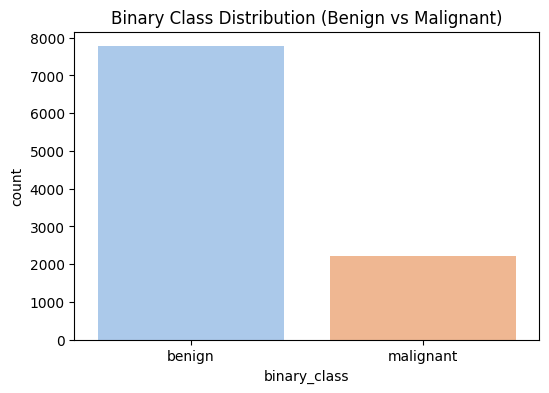

In [10]:
# FEATURE ENGINEERING: BINARY CLASS

df['binary_class'] = df['dx'].apply(lambda x: 'benign' if x in ['nv', 'bkl'] else 'malignant')

# Binary Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='binary_class', palette='pastel')
plt.title("Binary Class Distribution (Benign vs Malignant)")
plt.show()

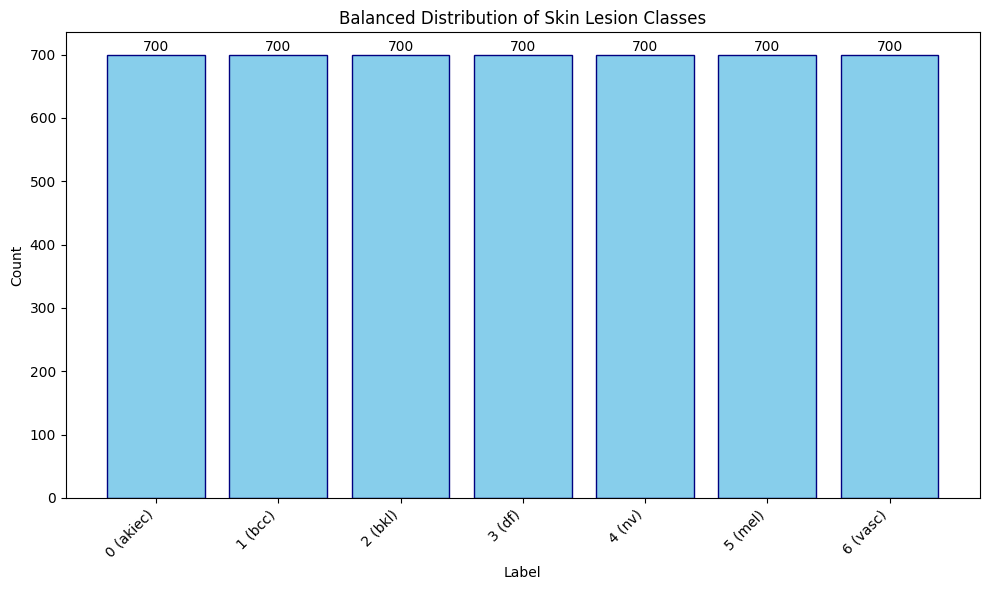

In [11]:
# BALANCE CLASSES (500 samples per class)
from sklearn.utils import resample

n_samples = 700
balanced_dfs = []

for label in df['dx_encoded'].unique():
    df_label = df[df['dx_encoded'] == label]
    df_label_balanced = resample(df_label, replace=True, n_samples=n_samples, random_state=42)
    balanced_dfs.append(df_label_balanced)

df_balanced = pd.concat(balanced_dfs).reset_index(drop=True)

# Balanced Class Distribution
plt.figure(figsize=(10,6))
class_counts = df_balanced['dx_encoded'].value_counts().sort_index()
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='navy')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balanced Distribution of Skin Lesion Classes')
plt.xticks(class_counts.index)

for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(count), ha='center')

class_names = list(encoder.classes_)
# Use both the index and the short names for the x-axis labels
short_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc']
x_tick_labels = [f"{idx} ({name})" for idx, name in enumerate(short_names)]
plt.xticks(class_counts.index, x_tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [12]:
# SAVE FINAL BALANCED DATA
df_balanced.to_csv('/content/preprocessed_balanced_ham10000_500.csv', index=False)
print("\n✅ Balanced dataset saved as 'preprocessed_balanced_ham10000_500.csv'")
from google.colab import files
files.download('/content/preprocessed_balanced_ham10000_500.csv')
!cp /content/preprocessed_balanced_ham10000_500.csv /content/drive/MyDrive/


✅ Balanced dataset saved as 'preprocessed_balanced_ham10000_500.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
df = pd.read_csv("/content/drive/MyDrive/preprocessed_balanced_ham10000_500.csv")
print("Dataset shape:", df.shape)

# Encode labels numerically
encoder = LabelEncoder()
df['dx_encoded'] = encoder.fit_transform(df['dx'])

# Features and labels
labels = df['dx_encoded'].values
num_classes = len(np.unique(labels))

Dataset shape: (4900, 10)


In [15]:
FilePath = "/content/drive/MyDrive/archive/hmnist_8_8_RGB.csv"
dataSet = pd.read_csv(FilePath)

In [16]:
IMG_SIZE = 128  # resize images

def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

In [17]:
# Assuming your images are in these directories within your Google Drive
image_dir_part1 = '/content/drive/MyDrive/archive/HAM10000_images_part_1'
image_dir_part2 = '/content/drive/MyDrive/archive/HAM10000_images_part_2'

# Create a list of all image file paths
image_files_part1 = [os.path.join(image_dir_part1, f + '.jpg') for f in df['image_id'] if os.path.exists(os.path.join(image_dir_part1, f + '.jpg'))]
image_files_part2 = [os.path.join(image_dir_part2, f + '.jpg') for f in df['image_id'] if os.path.exists(os.path.join(image_dir_part2, f + '.jpg'))]
file_paths = image_files_part1 + image_files_part2

# Ensure the number of file paths matches the number of labels
if len(file_paths) != len(labels):
    print("Warning: Number of image files does not match the number of labels.")
    # You might need to investigate missing files or labels here

# TRAIN-VALIDATION-TEST SPLIT

X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
# Convert to TensorFlow datasets
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(process_image).shuffle(1000).batch(BATCH_SIZE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(process_image).batch(BATCH_SIZE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(process_image).batch(BATCH_SIZE)

Training set size: 3920
Validation set size: 490
Test set size: 490


In [ ]:
# Check Performance on Different models
# Custom generator that resizes images on-the-fly
def custom_generator(X, y, batch_size, target_size=(224, 224)):
    while True:
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_x = X[start:end]
            batch_y = y[start:end]
            # Resize each image in the batch
            batch_x_resized = np.array([tf.image.resize(img, target_size).numpy() for img in batch_x])
            yield batch_x_resized, batch_y


# Create the pre-trained models with custom heads
def create_model(base_model, num_classes=7):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# List of models to evaluate
base_models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'DenseNet121': DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
}

# Setup generators
batch_size = 32
train_generator = custom_generator(X_train, y_train, batch_size=batch_size)
val_generator = custom_generator(X_val, y_val, batch_size=batch_size)
test_generator = custom_generator(X_test, y_test, batch_size=batch_size)

# Compile and evaluate each model
results = {}

for model_name, base_model in base_models.items():
    print(f"Training {model_name}...")

    if model_name == 'Custom_CNN':
        model = base_model
    else:
        model = create_model(base_model, num_classes=7)
        for layer in base_model.layers:
            layer.trainable = False  # Freeze the layers of the base model

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(train_generator,
              steps_per_epoch=len(X_train) // batch_size,
              validation_data=val_generator,
              validation_steps=len(X_val) // batch_size,
              epochs=8,
              callbacks=[reduce_lr, early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(test_generator, steps=len(X_test) // batch_size)
    results[model_name] = {'Test Loss': loss, 'Test Accuracy': accuracy}

# Print results summary
print("\nModel Performance Summary:")
for model_name, metrics in results.items():
    print(f"{model_name} - Test Loss: {metrics['Test Loss']:.4f}, Test Accuracy: {metrics['Test Accuracy']:.4f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training ResNet50...
Epoch 1/8
   1/1173 ━━━━━━━━━━━━━━━━━━━━ 5:25:14 17s/step - accuracy: 0.1562 - loss: 2.2506

I0000 00:00:1723428199.636887     141 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723428199.696467     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6367 - loss: 1.0304

W0000 00:00:1723428366.399235     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 203s 159ms/step - accuracy: 0.6368 - loss: 1.0302 - val_accuracy: 0.8427 - val_loss: 0.4962 - learning_rate: 1.0000e-04
Epoch 2/8
   3/1173 ━━━━━━━━━━━━━━━━━━━━ 1:34 80ms/step - accuracy: 0.7815 - loss: 0.6003

W0000 00:00:1723428392.311432     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8587 - loss: 0.4478

W0000 00:00:1723428562.390951     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 196s 162ms/step - accuracy: 0.8587 - loss: 0.4478 - val_accuracy: 0.8919 - val_loss: 0.3326 - learning_rate: 1.0000e-04
Epoch 3/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 182s 155ms/step - accuracy: 0.9134 - loss: 0.2955 - val_accuracy: 0.9268 - val_loss: 0.2437 - learning_rate: 1.0000e-04
Epoch 4/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 179s 153ms/step - accuracy: 0.9450 - loss: 0.2064 - val_accuracy: 0.9470 - val_loss: 0.1865 - learning_rate: 1.0000e-04
Epoch 5/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 181s 154ms/step - accuracy: 0.9642 - loss: 0.1486 - val_accuracy: 0.9584 - val_loss: 0.1501 - learning_rate: 1.0000e-04
Epoch 6/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 185s 158ms/step - accuracy: 0.9766 - loss: 0.1087 - val_accuracy: 0.9586 - val_loss: 0.1351 - learning_rate: 1.0000e-04
Epoch 7/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 176s 150ms/step - accuracy: 0.9834 - loss: 0.0810 - val_accuracy: 0.9599 - val_loss: 0.1328 - learning_rate: 1.0000e-04
Epoch 8/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 172

W0000 00:00:1723429712.852366     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.4512 - loss: 1.7196

W0000 00:00:1723429893.123488     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723429910.217042     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 250s 184ms/step - accuracy: 0.4513 - loss: 1.7192 - val_accuracy: 0.6595 - val_loss: 0.9384 - learning_rate: 1.0000e-04
Epoch 2/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 172s 147ms/step - accuracy: 0.6540 - loss: 0.9718 - val_accuracy: 0.7086 - val_loss: 0.8263 - learning_rate: 1.0000e-04
Epoch 3/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 172s 147ms/step - accuracy: 0.7085 - loss: 0.8267 - val_accuracy: 0.7237 - val_loss: 0.7894 - learning_rate: 1.0000e-04
Epoch 4/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 171s 146ms/step - accuracy: 0.7391 - loss: 0.7380 - val_accuracy: 0.7558 - val_loss: 0.7276 - learning_rate: 1.0000e-04
Epoch 5/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 169s 144ms/step - accuracy: 0.7658 - loss: 0.6717 - val_accuracy: 0.7571 - val_loss: 0.6659 - learning_rate: 1.0000e-04
Epoch 6/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 166s 141ms/step - accuracy: 0.7880 - loss: 0.6146 - val_accuracy: 0.7649 - val_loss: 0.6329 - learning_rate: 1.0000e-04
Epoch 7/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 162

In [ ]:
# Define the custom CNN model
def My_Model():
    input_ = Input(shape=[224, 224, 3])  # Adjusted input shape

    # First convolutional block with L2 regularization
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Third convolutional block
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Fourth convolutional block
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Flatten and dense layers with L2 regularization and dropout
    flatten = Flatten()(x)
    classifier = Dropout(rate=0.3)(flatten)
    classifier = Dense(units=256, activation='relu', kernel_initializer='he_normal',
                              kernel_regularizer=tf.keras.regularizers.l2(0.001))(classifier)
    classifier = BatchNormalization()(classifier)

    classifier = Dense(units=128, activation='relu', kernel_initializer='he_normal',
                              kernel_regularizer=tf.keras.regularizers.l2(0.001))(classifier)
    classifier = BatchNormalization()(classifier)

    classifier = Dense(units=64, activation='relu', kernel_initializer='he_normal',
                              kernel_regularizer=tf.keras.regularizers.l2(0.001))(classifier)
    classifier = BatchNormalization()(classifier)

    classifier = Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(),
                              kernel_initializer='he_normal')(classifier)
    classifier = BatchNormalization()(classifier)

    # Output layer
    classifier = Dense(units=7, activation='softmax', kernel_initializer="glorot_uniform", name='classifier')(classifier)

    return Model(inputs=input_, outputs=classifier)

# List of models to evaluate
base_models2 = {
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'Custom_CNN': My_Model()
}


# Compile and evaluate each model
results2 = {}

for model_name2, base_model2 in base_models2.items():
    print(f"Training {model_name2}...")

    if model_name2 == 'Custom_CNN':
        model2 = base_model2
    else:
        model2 = create_model(base_model2, num_classes=7)
        for layer in base_model2.layers:
            layer.trainable = False  # Freeze the layers of the base model

    # Compile the model
    model2.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model2.fit(train_generator,
              steps_per_epoch=len(X_train) // batch_size,
              validation_data=val_generator,
              validation_steps=len(X_val) // batch_size,
              epochs=8,
              callbacks=[reduce_lr, early_stopping])

    # Evaluate the model
    loss2, accuracy2 = model2.evaluate(test_generator, steps=len(X_test) // batch_size)
    results2[model_name2] = {'Test Loss': loss2, 'Test Accuracy': accuracy2}

# Print results summary
print("\nModel Performance Summary:")
for model_name2, metrics2 in results2.items():
    print(f"{model_name2} - Test Loss: {metrics2['Test Loss']:.4f}, Test Accuracy: {metrics2['Test Accuracy']:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training VGG16...
Epoch 1/8
   1/1173 ━━━━━━━━━━━━━━━━━━━━ 10:52:08 33s/step - accuracy: 0.1562 - loss: 3.5289

W0000 00:00:1723431277.712819     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5492 - loss: 1.2502

W0000 00:00:1723431512.080356     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723431539.603898     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 316s 241ms/step - accuracy: 0.5493 - loss: 1.2500 - val_accuracy: 0.7374 - val_loss: 0.7387 - learning_rate: 1.0000e-04
Epoch 2/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 247s 211ms/step - accuracy: 0.7613 - loss: 0.6873 - val_accuracy: 0.8050 - val_loss: 0.5730 - learning_rate: 1.0000e-04
Epoch 3/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 243s 208ms/step - accuracy: 0.8239 - loss: 0.5326 - val_accuracy: 0.8470 - val_loss: 0.4718 - learning_rate: 1.0000e-04
Epoch 4/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 245s 209ms/step - accuracy: 0.8625 - loss: 0.4316 - val_accuracy: 0.8756 - val_loss: 0.3975 - learning_rate: 1.0000e-04
Epoch 5/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 245s 209ms/step - accuracy: 0.8909 - loss: 0.3570 - val_accuracy: 0.8987 - val_loss: 0.3461 - learning_rate: 1.0000e-04
Epoch 6/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 239s 203ms/step - accuracy: 0.9133 - loss: 0.2976 - val_accuracy: 0.9088 - val_loss: 0.3051 - learning_rate: 1.0000e-04
Epoch 7/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 235

W0000 00:00:1723433314.073048     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1146/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.5980 - loss: 3.9079

W0000 00:00:1723433509.065015     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6009 - loss: 3.8995

W0000 00:00:1723433515.341804     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 254s 189ms/step - accuracy: 0.6010 - loss: 3.8992 - val_accuracy: 0.8876 - val_loss: 3.0539 - learning_rate: 1.0000e-04
Epoch 2/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 198s 169ms/step - accuracy: 0.8807 - loss: 2.9999 - val_accuracy: 0.9307 - val_loss: 2.7186 - learning_rate: 1.0000e-04
Epoch 3/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 199s 170ms/step - accuracy: 0.9399 - loss: 2.6318 - val_accuracy: 0.9356 - val_loss: 2.5266 - learning_rate: 1.0000e-04
Epoch 4/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 200s 171ms/step - accuracy: 0.9520 - loss: 2.3886 - val_accuracy: 0.9597 - val_loss: 2.2041 - learning_rate: 1.0000e-04
Epoch 5/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 204s 174ms/step - accuracy: 0.9694 - loss: 2.1535 - val_accuracy: 0.9652 - val_loss: 2.0338 - learning_rate: 1.0000e-04
Epoch 6/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 196s 167ms/step - accuracy: 0.9708 - loss: 1.9863 - val_accuracy: 0.9665 - val_loss: 1.8863 - learning_rate: 1.0000e-04
Epoch 7/8
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 186

In [ ]:
# Result Summary of all Models
# Combine the accuracy results from the two parts of your code
results_summary = {}

# Part 1: ResNet50 and DenseNet121
results_summary['ResNet50'] = {
    'Accuracy': results['ResNet50']['Test Accuracy']
}

results_summary['DenseNet121'] = {
    'Accuracy': results['DenseNet121']['Test Accuracy']
}

# Part 2: VGG16 and Custom CNN
results_summary['VGG16'] = {
    'Accuracy': results2['VGG16']['Test Accuracy']
}

results_summary['Custom_CNN'] = {
    'Accuracy': results2['Custom_CNN']['Test Accuracy']
}

# Print the final results summary
print("\nModel Performance Summary:")
print(f"{'Model':<15} {'Accuracy':<10}")
for model_name, metrics in results_summary.items():
    print(f"{model_name:<15} {metrics['Accuracy']:<10.4f}")



Model Performance Summary:
Model           Accuracy  
ResNet50        0.9664    
DenseNet121     0.7962    
VGG16           0.9411    
Custom_CNN      0.9735    


In [ ]:
# Proceed CNN Model
# Custom generator that resizes images on-the-fly
def custom_generator(X, y, batch_size, target_size=(224, 224)):
    while True:
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_x = X[start:end]
            batch_y = y[start:end]
            # Resize each image in the batch
            batch_x_resized = np.array([tf.image.resize(img, target_size).numpy() for img in batch_x])
            yield batch_x_resized, batch_y

# Setup generators
batch_size = 32
train_generator = custom_generator(X_train, y_train, batch_size=batch_size)
val_generator = custom_generator(X_val, y_val, batch_size=batch_size)
test_generator = custom_generator(X_test, y_test, batch_size=batch_size)
# Define the custom CNN model
def My_Model():
    input_ = Input(shape=[224, 224, 3])  # Adjusted input shape

    # First convolutional block with L2 regularization
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Third convolutional block
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Fourth convolutional block
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Flatten and dense layers with L2 regularization and dropout
    flatten = Flatten()(x)
    classifier = Dropout(rate=0.3)(flatten)
    classifier = Dense(units=256, activation='relu', kernel_initializer='he_normal',
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))(classifier)
    classifier = BatchNormalization()(classifier)

    classifier = Dense(units=128, activation='relu', kernel_initializer='he_normal',
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))(classifier)
    classifier = BatchNormalization()(classifier)

    classifier = Dense(units=64, activation='relu', kernel_initializer='he_normal',
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))(classifier)
    classifier = BatchNormalization()(classifier)

    classifier = Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(),
                       kernel_initializer='he_normal')(classifier)
    classifier = BatchNormalization()(classifier)

    # Output layer
    classifier = Dense(units=7, activation='softmax', kernel_initializer="glorot_uniform", name='classifier')(classifier)

    return Model(inputs=input_, outputs=classifier)

# Initialize the model
model = My_Model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save the history
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=val_generator,
                    validation_steps=len(X_val) // batch_size,
                    epochs=20,
                    callbacks=[reduce_lr, early_stopping])


Epoch 1/20

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 222s 172ms/step - accuracy: 0.5922 - loss: 3.9132 - val_accuracy: 0.8632 - val_loss: 3.1022 - learning_rate: 1.0000e-04

Epoch 2/20

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 208s 169ms/step - accuracy: 0.8839 - loss: 3.0051 - val_accuracy: 0.9384 - val_loss: 2.6896 - learning_rate: 1.0000e-04

Epoch 3/20

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 196s 167ms/step - accuracy: 0.9435 - loss: 2.6243 - val_accuracy: 0.9298 - val_loss: 2.5017 - learning_rate: 1.0000e-04

Epoch 4/20

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 195s 166ms/step - accuracy: 0.9549 - loss: 2.3823 - val_accuracy: 0.9670 - val_loss: 2.2106 - learning_rate: 1.0000e-04

Epoch 5/20

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 192s 164ms/step - accuracy: 0.9727 - loss: 2.1421 - val_accuracy: 0.9640 - val_loss: 2.0335 - learning_rate: 1.0000e-04

Epoch 6/20

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 191s 163ms/step - accuracy: 0.9731 - loss: 1.9663 - val_accuracy: 0.9693 - val_loss: 1.8750 - learning_rate: 1.0000e-04

Epoch 7/20

1173

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=len(X_test) // batch_size)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9713 - loss: 0.8518

Test Loss: 0.8483, Test Accuracy: 0.9730


In [ ]:
# Reducing Image Size and train Again cnn Model
# Callback for reducing learning rate when validation accuracy plateaus
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

# Early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# model with L2 regularization and fine-tuned dropout rates
def My_Model():
    input_ = layers.Input(shape=[28, 28, 3])

    # First convolutional block with L2 regularization
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.001))(input_)
    x = layers.MaxPooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Third convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Fourth convolutional block
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Flatten and dense layers with L2 regularization and dropout
    flatten = layers.Flatten()(x)
    classifier = layers.Dropout(rate=0.3)(flatten)
    classifier = layers.Dense(units=256, activation='relu', kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.l2(0.001))(classifier)
    classifier = layers.BatchNormalization()(classifier)

    classifier = layers.Dense(units=128, activation='relu', kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.l2(0.001))(classifier)
    classifier = layers.BatchNormalization()(classifier)

    classifier = layers.Dense(units=64, activation='relu', kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.l2(0.001))(classifier)
    classifier = layers.BatchNormalization()(classifier)

    classifier = layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.L1L2(),
                              kernel_initializer='he_normal')(classifier)
    classifier = layers.BatchNormalization()(classifier)

    # Output layer
    classifier = layers.Dense(units=7, activation='softmax', kernel_initializer="glorot_uniform", name='classifier')(classifier)

    return models.Model(inputs=input_, outputs=classifier)
model=My_Model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,276,103 (4.87 MB)

 Trainable params: 1,274,183 (4.86 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# Train the model with early stopping and learning rate reduction
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/30

294/294 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.5357 - loss: 3.9456 - val_accuracy: 0.7089 - val_loss: 3.0738 - learning_rate: 0.0010

Epoch 2/30

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8380 - loss: 2.5847 - val_accuracy: 0.7145 - val_loss: 2.5197 - learning_rate: 0.0010

Epoch 3/30

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8940 - loss: 1.9233 - val_accuracy: 0.8283 - val_loss: 1.8190 - learning_rate: 0.0010

Epoch 4/30

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9111 - loss: 1.4963 - val_accuracy: 0.7893 - val_loss: 1.6565 - learning_rate: 0.0010

Epoch 5/30

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9230 - loss: 1.2209 - val_accuracy: 0.8685 - val_loss: 1.2386 - learning_rate: 0.0010

Epoch 6/30

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9369 - loss: 1.0177 - val_accuracy: 0.8979 - val_loss: 1.0389 - learning_rate: 0.0010

Epoch 7/30

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9

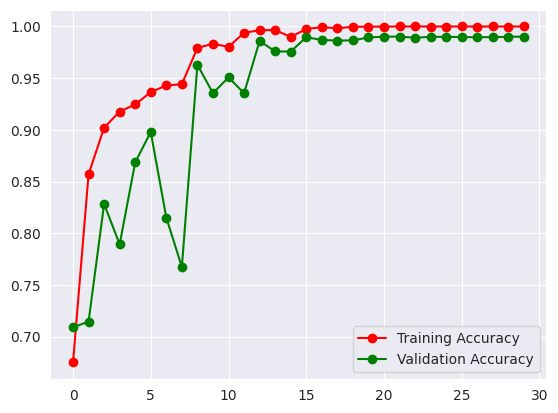

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Validation Accuracy")
plt.legend()
plt.show()

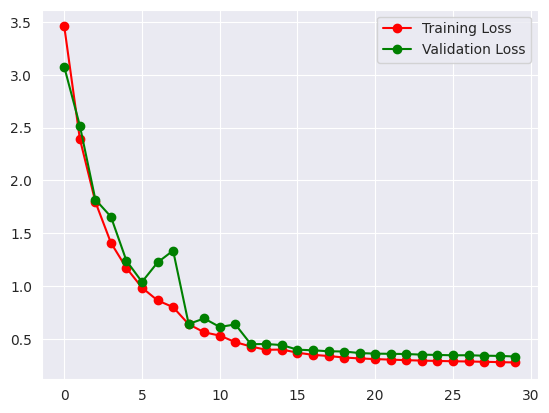

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Classification Report on Test Data
# Define the class names and their short names
class_names = {
    0: 'Actinic Keratoses',  # akiec
    1: 'Basal Cell Carcinoma',  # bcc
    2: 'Benign Keratosis-like Lesions',  # bkl
    3: 'Dermatofibroma',  # df
    4: 'Melanocytic Nevi',  # nv
    5: 'Melanoma',  # mel
    6: 'Vascular Lesions'  # vasc
}

# Short names for confusion matrix
short_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc']


# Evaluate the model on the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(short_names)))

# Show the class names with their indices
print("\nFull Class Names with Short name:")
for index, name in class_names.items():
    print(f"       {short_names[index]}: {name}")


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:

              precision    recall  f1-score   support



       akiec       1.00      1.00      1.00       666

         bcc       0.99      1.00      1.00       675

         bkl       0.97      1.00      0.99       668

          df       1.00      1.00      1.00       669

          nv       1.00      0.92      0.96       652

         mel       1.00      1.00      1.00       667

        vasc       0.96      1.00      0.98       697



    accuracy                           0.99      4694

   macro avg       0.99      0.99      0.99      4694

weighted avg       0.99      0.99      0.99      4694





Full Class Names with Short name:

       akiec: Actinic Keratoses

       bcc: Basal Cell Carcinoma

       bkl: Benign Keratosis-like Lesions

       df: Dermatofibroma

       nv: Melanocytic Nevi

       mel: Melanoma

       vasc: Vascular Lesions


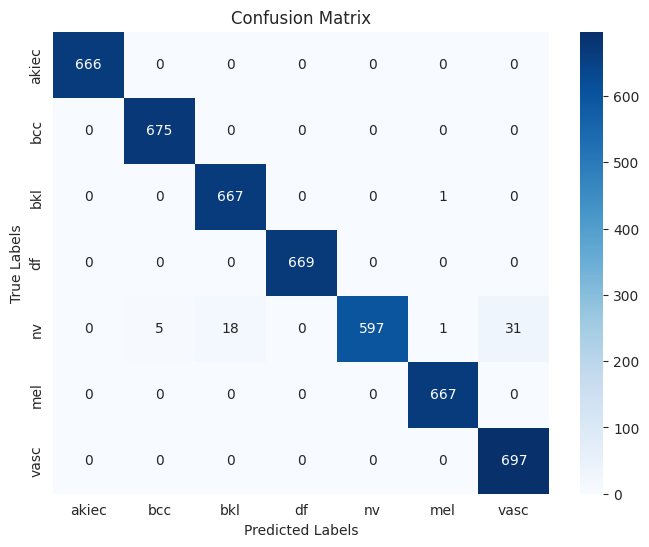

In [ ]:
# Confusiion Matrix
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with short names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=short_names, yticklabels=short_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

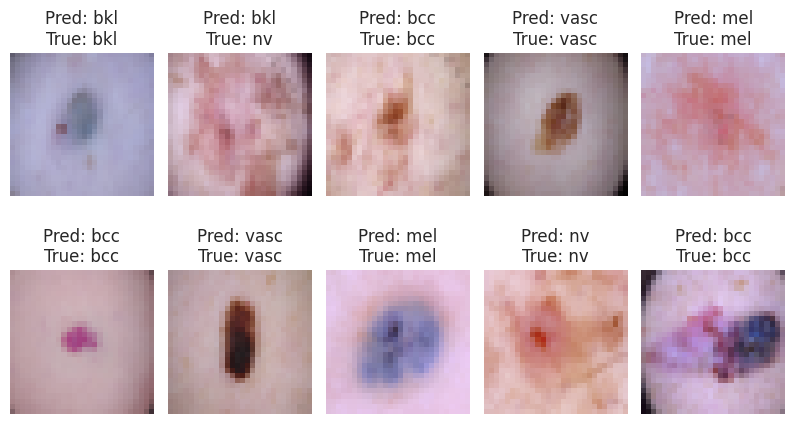

In [ ]:
#Prediction
# Assuming correct is a list of indices where the model correctly classified the images
correct = [12,1,2,13,55,5,16,78,8,11]

plt.figure(figsize=(10, 5))
for i, c in enumerate(correct[:10]):  # Loop through the first 10 correct indices
    plt.subplot(2, 5, i + 1)  # Arrange the plots in a 2x5 grid
    plt.imshow(X_val[c])
    plt.title(f"Pred: {short_names[y_pred_classes[c]]}\nTrue: {short_names[y_true[c]]}")
    plt.axis('off')

# Adjust the space between rows and columns
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Reduce hspace to reduce vertical space between rows

plt.show()


In [ ]:
# Assuming correct is a list of correctly classified examples
for c in correct[:10]:
    print(f"Index: {c}, Predicted: {y_pred_classes[c]}, True: {y_true[c]}")


Index: 12, Predicted: 2, True: 2

Index: 1, Predicted: 2, True: 4

Index: 2, Predicted: 1, True: 1

Index: 13, Predicted: 6, True: 6

Index: 55, Predicted: 5, True: 5

Index: 5, Predicted: 1, True: 1

Index: 16, Predicted: 6, True: 6

Index: 78, Predicted: 5, True: 5

Index: 8, Predicted: 4, True: 4

Index: 11, Predicted: 1, True: 1
